# Policy Gradient Methods for Gym Environments

**References**:

- "Reinforcement Learning, An Introduction" book by Richard Sutton, chapter 13.
- [PyTorch documentation](https://pytorch.org/docs/stable/index.html)

**In this notebook I will**
- Implement REINFORCE algorithm
- Implement A2C algorithm
- Implement DDPG algorithm


In [ ]:
!pip install gym
!pip install gym[classic_control]
!pip install tqdm seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing required packages
import gym
import numpy as np
import time
import random
from tqdm import tqdm
from typing import Tuple
from copy import deepcopy

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:

SEED = 54321

def reset_seed():
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  np.random.seed(SEED)
  random.seed(SEED)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 1. Environments with continuous spaces



## 1.1 CartPole


Because CartPole has a continuous observation space with an infinite number of possible observations, using tabular methods to solve it is not feasible due to the limitations of finite memory capacity.

![cartpole_image](https://www.gymlibrary.dev/_images/cart_pole.gif)

## 1.2 Pendulum

Pendulum has a continuous observation and action space, meaning that there are infinite possible observations and actions for each state.

![pendulum_image](https://www.gymlibrary.dev/_images/pendulum.gif)

In [ ]:

env = gym.make("CartPole-v1")
print("action space:", env.action_space)
print("sample of action:", env.action_space.sample())
print("observation space:", env.observation_space.shape)
print("sample of observation:", env.observation_space.sample())
print()

env = gym.make("Pendulum-v1")
print("action space:", env.action_space)
print("sample of action:", env.action_space.sample())
print("observation space:", env.observation_space)
print("sample of observation:", env.observation_space.sample())


action space: Discrete(2)
sample of action: 0
observation space: (4,)
sample of observation: [-2.0340610e+00 -1.9250664e+38 -3.6233506e-01  3.2536727e+37]

action space: Box(-2.0, 2.0, (1,), float32)
sample of action: [-1.0505743]
observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
sample of observation: [0.74007833 0.5508447  4.154338  ]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# 2. REINFORCE

Policy-based RL focuses on learning a policy $\pi(a | s)$, which is a probability distribution over actions $a$ given the current state $s$.
In other words, The goal of policy-based methods is directly parameterizing the **policy**.

$$\pi_\theta (a | s) = \mathbb{P} \left[ a | s, \theta \right]$$

However, the goal remains to find the optimal policy that maximizes the expected cumulative reward. Let $J(\theta)$ be any policy objective function, and the goal of policy-based RL is to find the parameter $\theta^* \doteq \max_\theta J(\theta)$.





## 2.1 REINFORCE

REINFORCE is a policy-based RL algorithm that uses gradient ascent to optimize the policy.
The key idea behind REINFORCE is to adjust the policy parameters $\theta$ in the direction of the gradient of the expected reward.
The update rule is as follows:

$$\theta \gets \theta + \alpha \times \sum_t \nabla_\theta G_t \log \pi_\theta(a_t|s_t))$$

where $\alpha$ is learning rate and $G_t$ is return value.

### 2.1.1 REINFORCE training steps

The algorithm can be summarized in the following steps:

1. Initialize the policy parameter $\theta$ randomly.
2. Generate an episode using the current policy $\pi_\theta (a|s)$.
3. For each time step $t$ in the episode:
  - Calculate the return $G_t$ from time step $t$ until the end of the episode.
  - Update the new policy parameter $\theta$ using the update rule.
4. Repeat steps 2-3 until convergence or a stopping criterion is met.


In [ ]:
class REINFORCE:

  def __init__(self, policy_model: nn.Module, lr: float, solve_criteria: float, episode_limit: int):
    self.policy_model = policy_model
    self.optimizer = optim.Adam(self.policy_model.parameters(), lr=lr)
    self.solve_criteria = solve_criteria
    self.episode_limit = episode_limit


  def calculate_loss(self) -> torch.Tensor:
    DISCOUNT_FACTOR = 0.99  

    timestep_return = 0;
    returns = []
    loss = []
    for reward in reversed(self.rewards):
      timestep_return =  DISCOUNT_FACTOR * timestep_return + reward
      returns.append(timestep_return)

    # Because we are appending to the right,return from the first timestep is placed last
    # Thus we need to reverse the array
    returns = returns[::-1]

    # Calculate the loss based on the return values above.
    for log_prob, timestep_return in zip(self.log_probs, returns):
      loss.append((-1) * log_prob * timestep_return)
    # </TODO>
    loss = torch.cat(loss).sum()
    return loss 

  def optimize(self):
    loss = self.calculate_loss()

    # Update the policy model with the loss above.
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def interaction_step(self, state, env):
    action, log_prob = self.policy_model.full_pass(state)
    new_state, reward, done, _ = env.step(action)
    reward = float(reward)

    self.log_probs.append(log_prob)
    self.rewards.append(reward)

    return new_state, done

  def train(self, env):
    total_rewards = []
    pbar = tqdm(range(1, self.episode_limit + 1))
    solved = False
    for episode in pbar:
      state, done = env.reset(seed=SEED), False

      self.log_probs = []
      self.rewards = []

      # Interact with the environment and update the model
      for i in range(1000):
        state, done = self.interaction_step(state, env)
        if(done == True): break

      self.optimize()

      total_reward = sum(self.rewards)
      total_rewards.append(total_reward)

      avg_rewards = np.mean(total_rewards[-10:])
      pbar.set_description(f"reward avg: {avg_rewards:.2f} min: {min(total_rewards):.2f} max: {max(total_rewards):.2f}")
      if avg_rewards >= self.solve_criteria:
        print(f"\nSOLVED in {episode} episodes!")
        solved = True
        break

    if not solved:
      raise Exception("Not solved.")

    return total_rewards

### 2.1.2 Softmax Policy

There are various ways to represent policies, and two common types are Softmax Policy and Gaussian Policy.
Both policies have their advantages and are suited for different types of problems.

Softmax Policy is used in discrete action spaces. The policy is defined by a probability distribution over the possible actions in a given state, which is determined by applying the softmax function to the action preferences.

The softmax policy is defined as:

$$\pi_\theta (a|s) = \frac{\exp(\phi(s, a)^\top \theta)} {\sum_{a^\prime} \exp(\phi(s, a^\prime)^\top \theta)}$$



In [ ]:
class SoftmaxPolicy(nn.Module):
  def __init__(self, in_features: int, out_features: int):
    # in_features: the size of state representation
    # out_features: the size of action representation
    super(SoftmaxPolicy, self).__init__()
  
    self.layer1 = nn.Linear(in_features, 32)
    self.layer2 = nn.Linear(32, out_features)
    self.layer3 = nn.Softmax(dim = -1)


  def forward(self, x) -> torch.Tensor:
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.unsqueeze(0)

    x = F.tanh(self.layer1(x))
    x = self.layer2(x)
    x = self.layer3(x)
    return x

  def full_pass(self, state):
    probs = self.forward(state)
    dist = torch.distributions.Categorical(probs)

    action = dist.sample()
    log_prob = dist.log_prob(action)
    return action.item(), log_prob

CartPole has a discrete action space. Hence, Softmax Policy is suitable for solving CartPole task.

In [ ]:
env = gym.make("CartPole-v1")

In [ ]:
lr = 0.002

reset_seed()
policy = SoftmaxPolicy(env.observation_space.shape[0], env.action_space.n)
agent = REINFORCE(policy, lr, solve_criteria=450, episode_limit=1000)

cat_vanilla_reinforce_total_rewards = agent.train(env)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
reward avg: 467.70 min: 11.00 max: 500.00:  40%|████      | 400/1000 [01:33<02:19,  4.29it/s]


SOLVED in 401 episodes!


Let's see the training result.

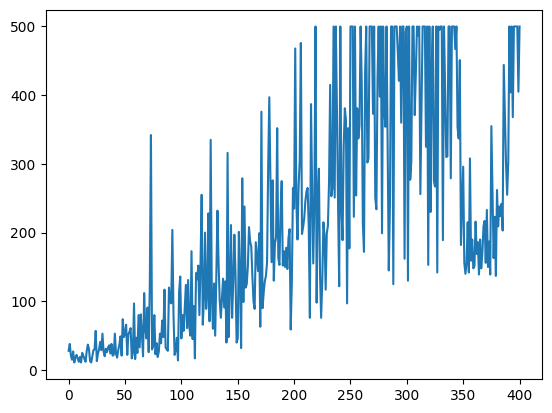

In [ ]:
plt.plot(cat_vanilla_reinforce_total_rewards);

## 2.2 REINFORCE with Baseline

The vanilla REINFORCE algorithm has high variance because it relies solely on the sampled trajectories to estimate the gradient of the policy.
Since the return value from each trajectory depends on the stochasticity of the environment and the policy, the sampled returns can be pretty diverse, leading to noisy gradient estimates.

Introducing a baseline helps to reduce the variance of these gradient estimates.
The idea is to subtract a baseline value from the returns, which effectively centers the returns around zero.
Common choices for the baselines are the average return values or a value function approximating the expected return for each state.

When using a baseline, the update rule for the policy parameters becomes:

$$\theta \gets \theta + \alpha \times \sum_t \nabla_\theta (G_t - b(s_t)) \log \pi_\theta (a_t|s_t)$$

The term $(G_t - b(s_t))$ is called the advantage, representing how much better the sampled return is compared to the baseline.

Using a baseline reduces the variance because it centers the advantage values around zero, making the gradient updates less influenced by the inherent noise in the sampled returns.
Suppose the baseline is a good approximation of the expected return. In that case, the advantage values will be close to zero for actions that perform as expected and larger or smaller for actions that perform better or worse, respectively.
This leads to more stable and efficient learning in the REINFORCE algorithm.

In this case, we use the average of return values as the baseline
(i.e., $b(s_t) = \sum_{i=1}^{T} G_i / T$).

In [ ]:
class REINFORCE_baseline(REINFORCE):
  def calculate_loss(self) -> torch.Tensor:
    DISCOUNT_FACTOR = 0.99  

    timestep_return = 0;
    returns = []
    # First, calculate the return values for each time step
    for reward in reversed(self.rewards):
      timestep_return = DISCOUNT_FACTOR * timestep_return + reward
      returns.append(timestep_return)

    returns = returns[::-1]
    mean_return = np.mean(returns)
    # Second, calculate the advantage values.
    advantage_vals = returns - mean_return
    # Calculate the loss based on the advantage values above.
    loss = [(-1) * log_prob * advantage for log_prob, advantage in zip(self.log_probs, advantage_vals)]
    loss = torch.cat(loss).sum()
    return loss

Let's run the training! 

In [ ]:
lr = 0.002

reset_seed()
policy = SoftmaxPolicy(env.observation_space.shape[0], env.action_space.n)
agent = REINFORCE_baseline(policy, lr, solve_criteria=450, episode_limit=800)

cat_baseline_reinforce_total_rewards = agent.train(env)

reward avg: 451.00 min: 10.00 max: 500.00:  27%|██▋       | 216/800 [00:39<01:47,  5.41it/s]


SOLVED in 217 episodes!


Let's see the training result! You may see the baseline version solves faster compared to the vanilla version.

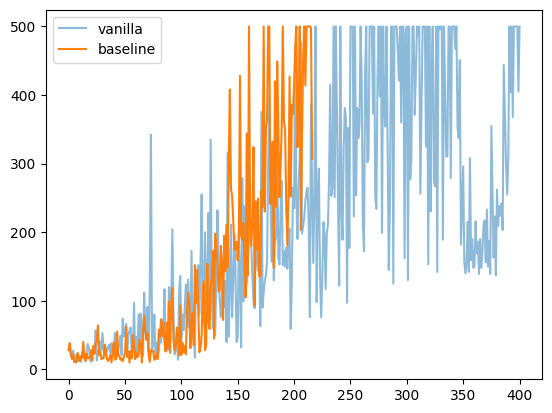

In [ ]:
plt.plot(cat_vanilla_reinforce_total_rewards, label="vanilla", alpha=0.5);
plt.plot(cat_baseline_reinforce_total_rewards, label="baseline");
plt.legend(loc="upper left");


# 3. Actor-Critic

As mentioned above, we can use the value function $v(s)$ as a baseline of REINFORCE algorithm.
However, we cannot use it directly because we do not know the value, $v(s)$.

We can make a value function with a neural network just as we approximated a policy with a neural network.
In other words, we now have two types of neural networks: policy and value networks.
The policy network $\pi_\theta (a|s)$ is called the *actor*, because it tells us what to do. The other network, the value network, is called the *critic*, because it tells us how good our actions were. This architecture is called Actor-Critic.

## 3.1 Advantage Actor-Critic (A2C)

Advanced Actor-Critic (A2C) is a reinforcement learning algorithm that combines the Actor-Critic architecture with an advantage function, representing the relative benefit of a particular action compared to the average action in a given state. Now we have a value function $v_{\theta_v}(s_t)$, the advantage of an action $a_t$ can be defined as:

$$\mathrm{adv}_{\theta_v}(s_t) \doteq \bigl[ R_{t+1} + \gamma v_{\theta_v}(s_{t+1}) \bigr] - v_{\theta_v} (s_t)$$

The update rule of A2C is as follows:

$$\theta_\pi \gets \theta_\pi + \alpha \times \sum_t \nabla_{\theta_\pi} \Bigl[ \mathrm{adv}_{\theta_v}(s_t) \log \pi_{\theta_\pi}(a_t|s_t) \Bigr]$$

$$\theta_v \gets \theta_v - \alpha \times \sum_t \nabla_{\theta_v} \Bigl[ v_{\theta_v}(s_t) - \bigl(R_{t+1} + \gamma v_{\theta_v} (s_{t+1})\bigr)\Bigr]^2$$

We do not need to wait until the episode finishes because the update rule above has no return value $G_t$.

### 3.1.1 A2C training steps

The algorithm can be summarized in the following steps:

1. Initialize network parameters $\theta$ randomly.
2. Interaction with the environment and training the agent.
  1. Generate an action $a_t$ from the agent at the state $s_t$.
  2. Get $s_{t+1}$ and $R_{t+1}$ from the environment.
  3. Update the agent parameters $\theta_\pi$ and $\theta_v$.
3. Repeat step 2 until convergence or a stopping criterion is met.


In [ ]:
class A2C:

  def __init__(self, actor_model: nn.Module, critic_model: nn.Module, actor_lr: float, critic_lr: float, solve_criteria: float, episode_limit: int):
    self.actor_model = actor_model
    self.critic_model = critic_model
    self.actor_optimizer = optim.Adam(self.actor_model.parameters(), lr=actor_lr)
    self.critic_optimizer = optim.Adam(self.critic_model.parameters(), lr=critic_lr)
    self.solve_criteria = solve_criteria
    self.episode_limit = episode_limit

  def calculate_loss(self, state, log_prob, reward, next_state, done) -> Tuple[torch.Tensor, torch.Tensor]:
    DISCOUNT_FACTOR = 0.99  
    
    actor_loss = []
    critic_loss = []
    v_state = self.critic_model.forward(state)
    v_next_state = self.critic_model.forward(next_state)
    # calculate the actor loss
    adv = (reward + DISCOUNT_FACTOR * v_next_state) - v_state
    actor_loss.append(-1 * adv * log_prob)
    # calculate the critic loss
    critic_loss.append(pow(adv, 2))
    actor_loss = torch.cat(actor_loss).sum()
    critic_loss = torch.cat(critic_loss).sum()

    return actor_loss, critic_loss

  def optimize(self, state, log_prob, reward, new_state, done):
    actor_loss, critic_loss = self.calculate_loss(state, log_prob, reward, new_state, done)

    # Update the actor and critic networks with the losses above.
    self.actor_optimizer.zero_grad()
    actor_loss.backward(retain_graph=True)
    self.actor_optimizer.step()

    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()

  def interaction_step(self, state, env):
    action, log_prob = self.actor_model.full_pass(state)
    new_state, reward, done, _ = env.step(action)
    reward = float(reward)

    self.rewards.append(reward)

    return log_prob, reward, new_state, done

  def train(self, env):

    total_rewards = []
    pbar = tqdm(range(1, self.episode_limit + 1))
    solved = False
    for episode in pbar:
      state, done = env.reset(seed=SEED), False

      self.rewards = []

      # Interact with the environment and update the model
      for i in range(1000):
        log_prob, reward, new_state, done = self.interaction_step(state,env)
        self.optimize(state, log_prob, reward, new_state, done)
        state = new_state
        if(done == True): break

      total_reward = sum(self.rewards)
      total_rewards.append(total_reward)

      avg_rewards = np.mean(total_rewards[-10:])
      pbar.set_description(f"reward avg: {avg_rewards:.2f} min: {min(total_rewards):.2f} max: {max(total_rewards):.2f}")
      if avg_rewards >= self.solve_criteria:
        print(f"\nSOLVED in {episode} episodes!")
        solved = True
        break

    if not solved:
      raise Exception("Not solved.")

    return total_rewards

### 2.1.2 Critic Network

The role of the critic network is to estimate the value. Therefore, the output of the critic network is scalar (i.e., $v_{\theta_v}(s) \in \mathbb{R}$).


In [ ]:
class Critic(nn.Module):
  def __init__(self, in_features: int):
    # in_features: the size of state representation
    super(Critic, self).__init__()

    self.layer1 = nn.Linear(in_features, 32)
    self.layer2 = nn.Linear(32, 1)

  def forward(self, x) -> torch.Tensor:
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.unsqueeze(0)
    
    x = F.tanh(self.layer1(x))
    x = self.layer2(x)
    return x

Let's run the training! 

In [ ]:
actor_lr = 0.002
critic_lr = 0.002

reset_seed()
policy = SoftmaxPolicy(env.observation_space.shape[0], env.action_space.n)
critic = Critic(env.observation_space.shape[0])
agent = A2C(policy, critic, actor_lr, critic_lr, solve_criteria=450, episode_limit=800)

cat_a2c_total_rewards = agent.train(env)

reward avg: 451.60 min: 12.00 max: 500.00:  13%|█▎        | 101/800 [00:38<04:25,  2.63it/s]


SOLVED in 102 episodes!


Let's see the training result!

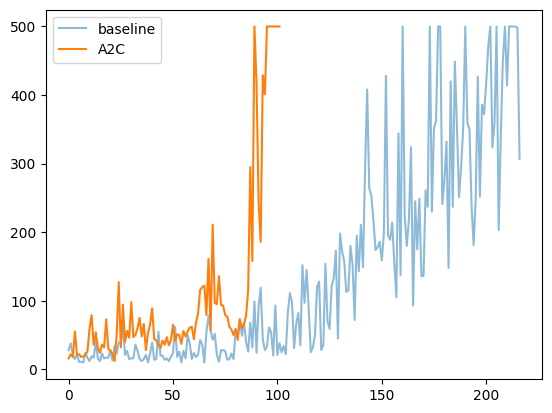

In [ ]:
plt.plot(cat_baseline_reinforce_total_rewards, label="baseline", alpha=0.5);
plt.plot(cat_a2c_total_rewards, label="A2C");
plt.legend(loc="upper left");

# 4. DDPG

**Deep Deterministic Policy Gradient (DDPG)** is an Actor-Critic, model-free algorithm based on the deterministic policy gradient that can operate over continuous action space.
DDPG adapts the ideas underlying the success of Deep Q-Learning to the continuous action domain (DQN is unsuitable for continuous action spaces).

We have only dealt with discrete action spaces so far. Now move on to the continuous action space. DDPG can operate over continuous action spaces. Hence, let's implement DDPG algorithm with Pendulum environment that has a continuous action space.

In [ ]:
env = gym.make("Pendulum-v1")

## 4.1 Actor-Critic Architecture in DDPG

**Deep Deterministic Policy Gradient (DDPG)** is a kind of Actor-Critic algorithm with a deterministic policy. Recall the implementation of the `SoftmaxPolicy`, where the `sample` method was called. In other words, the Softmax policy we implemented is stochastic.
In this case, we can describe an action as $a_t \sim \pi_\theta(a|s)$.

Now, let's discuss how to make a deterministic policy. The solution is quite simple. With a parameterized deterministic policy, the output of the actor-network is the action (i.e., $a_t = \pi_\theta(s_t)$).
In the case of stochastic policy, sampling is exploration itself. However, in the case of deterministic policy, we need an exploration method such as epsilon-greedy.


In [ ]:
class DDPGActor(nn.Module):
  def __init__(self, in_features: int, out_features: int, action_range: float):
    # in_features: the size of state representation
    # out_features: the size of action representation
    super(DDPGActor, self).__init__()

    self.action_range = action_range

    self.layer1 = nn.Linear(in_features, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, out_features)
    self.layer4 = nn.Tanh()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.squeeze(-1).unsqueeze(0)

    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = self.layer3(x)
    x = self.action_range * self.layer4(x)
    
    return x


Unlike A2C, DDPG's critic network requires both state and action. Let's see the difference.

- In A2C: $v(s_t) = \mathrm{Critic}_{\theta_v}(s_t)$
- In DDPG: $v(s_t) = \mathrm{Critic}_{\theta_v}(s_t, a_t)$

In [ ]:
class DDPGCritic(nn.Module):
  def __init__(self, in_features_obs, in_features_act):
    # in_features_obs: the size of state representation
    # in_features_act: the size of action representation
    super(DDPGCritic, self).__init__()

    self.layer1 = nn.Linear(in_features_obs+in_features_act, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, 1)

  def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
    if not isinstance(state, torch.Tensor):
      state = torch.tensor(state, dtype=torch.float32)
      state = state.squeeze(-1).unsqueeze(0)

    if not isinstance(action, torch.Tensor):
      action = torch.tensor(action, dtype=torch.float32)
      action = action.unsqueeze(0)

    x = torch.cat([state, action], dim=1)
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = self.layer3(x)
    return x

## 4.2 Replay Buffer

Replay Buffer stores past experiences and enables the algorithm to sample and learn from these experiences more efficiently and stably, breaking the correlation between consecutive samples and mitigating the issue of non-stationarity caused by the constantly updating policy and value function approximators.

To train Actor-Critic architecture, transition data ($s_t$, $a_t$, $R_{t+1}$, $s_{t+1}$, $\delta_{t+1}$) is required, where $\delta_{t+1}$ is `done` in the code below. Hence, the replay buffer should store transitions. The replay buffer should provide an operation: sample mini-batch from the buffer.


In [ ]:
class ReplayBuffer:
  def __init__(self, capacity: int):
    self.capacity = capacity
    self.buffer = []

  def push(self, transition):
    if(len(self.buffer) == self.capacity):
        self.buffer.pop(0)
    self.buffer.append(transition)


  def sample(self, batch_size: int):
    return random.sample(self.buffer, batch_size)

  def __len__(self):
    return len(self.buffer)

## 4.3 DDPG algorithm

![alt text](https://i.imgur.com/mS6iGyJ.jpg)

In [ ]:
class DDPG:
  def __init__(self, buffer: ReplayBuffer, actor: DDPGActor, critic: DDPGCritic, actor_lr: float, critic_lr: float, solve_criteria: float, episode_limit: int):
    self.buffer = buffer

    self.actor = actor
    self.critic = critic
    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

    self.target_actor = deepcopy(self.actor)
    self.target_critic = deepcopy(self.critic)

    self.solve_criteria = solve_criteria
    self.episode_limit = episode_limit

  @staticmethod
  def soft_target_update(net: nn.Module, target_net: nn.Module, tau: float):
    for param, target_param in zip(net.parameters(), target_net.parameters()):
      target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

  def update(self):
    BATCH_SIZE = 64
    DISCOUNT_FACTOR = 0.99
    TAU = 0.005
    
    # Sample replay buffer and calculate critic loss.
    if len(self.buffer) < BATCH_SIZE: return
    sample_transitions = self.buffer.sample(BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*sample_transitions)

    states = torch.FloatTensor(states)
    actions = torch.FloatTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    next_actions = self.target_actor(next_states)
    current_Qvals = self.critic(states, actions)
    next_Qvals = self.target_critic(next_states, next_actions)

    Y = DISCOUNT_FACTOR * next_Qvals * (1-dones.unsqueeze(1)) + rewards.unsqueeze(1)
    critic_loss = F.mse_loss(Y, current_Qvals)

    # With loss above, update the critic network.
    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()

    # Calculate actor loss and update the actor network.
    actor_loss = -self.critic(states, self.actor(states))
    actor_loss = actor_loss.mean()
    
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

    # Update the target networks
    self.soft_target_update(self.critic, self.target_critic, TAU)
    self.soft_target_update(self.actor, self.target_actor, TAU)

  def interaction_step(self, state, env):
    action = self.actor(state)
    action = action.detach().numpy().flatten()

    # Policy is deterministic, therefore we need to add a noise to action for exploration.
    # A noise can be sampled from a Gaussian distribution.
    action += np.random.normal(scale = 0.1, size = action.shape)

    new_state, reward, done, _ = env.step(action)
    reward = float(reward)

    return action, reward, new_state, done

  def train(self, env):

    total_rewards = []
    pbar = tqdm(range(1, self.episode_limit + 1))
    solved = False
    ctr = 0
    for episode in pbar:
      state, done = env.reset(seed=SEED), False

      self.rewards = []

      while(1):
        ctr+=1
        action, reward, new_state, done = self.interaction_step(state, env)
        self.buffer.push([state, action, reward, new_state, done])
        if(done == True): break
        state = new_state
        self.rewards.append(reward)
        if(ctr%5 == 0): self.update()


      total_reward = sum(self.rewards)
      total_rewards.append(total_reward)

      avg_rewards = np.mean(total_rewards[-10:])
      pbar.set_description(f"reward avg: {avg_rewards:.2f} min: {min(total_rewards):.2f} max: {max(total_rewards):.2f}")
      if avg_rewards >= self.solve_criteria:
        print(f"\nSOLVED in {episode} episodes!")
        solved = True
        break

    if not solved:
      raise Exception("Not solved.")

    return total_rewards

Let's run the training! Feel free to change the learning rates.

In [ ]:
actor_lr = 0.001
critic_lr = 0.001

reset_seed()
buffer = ReplayBuffer(10000)
actor = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0], 2)
critic = DDPGCritic(env.observation_space.shape[0], env.action_space.shape[0])
agent = DDPG(buffer, actor, critic, actor_lr, critic_lr, solve_criteria=-200, episode_limit=300)

ddpg_total_rewards = agent.train(env)

  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-21-3519aeb06943>:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  states = torch.FloatTensor(states)
reward avg: -184.26 min: -1664.74 max: -129.44:  64%|██████▍   | 192/300 [01:12<00:40,  2.64it/s]


SOLVED in 193 episodes!


Let's see the result!

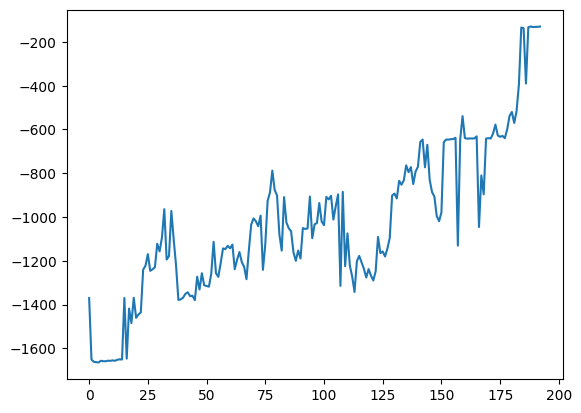

In [ ]:
plt.plot(ddpg_total_rewards);
